In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math

# Define our buildDataSet function here!

In [4]:
def buildDataSet(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size):
    sparse_data = np.zeros((vector_size, data_set_size), dtype=float)  # Ensure float type
    
    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity, max_sparsity)
        indices = random.sample(range(vector_size), sparsity)
        amps = np.random.uniform(-max_amplitude, max_amplitude, sparsity)  # Use negative and positive values
        sparse_data[indices, i] = amps
    
    # Define the DFT matrix and multiply our sparse_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size) / np.sqrt(vector_size)
    dense_data = DFT @ sparse_data
    
    return dense_data, sparse_data




## Build the dataset

In [ ]:
max_amplitude = 100
min_sparsity = 3
max_sparsity = 5
vector_size = 100
data_set_size = 10000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)



133.90447374499485


## Test the dataset

In [6]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

# Check if the iDFT of the dense data is in fact sparse
print(iDFT@dense_data)


[[-1.90440988e-14-2.62048259e-13j -1.14011185e-14-1.29165196e-13j
   8.40040586e-15-1.47045081e-14j ...  1.29108196e-13+1.69225904e-13j
  -9.45420274e-14+3.51440167e-13j  3.60330530e-14+8.15336709e-14j]
 [-1.39135764e-13-3.62141203e-14j -1.29440412e-13-2.43497378e-14j
   2.62012634e-14+1.10585157e-14j ...  2.92386469e-14+6.95374444e-14j
   1.21696445e-13+2.33112541e-16j -6.34526450e-14-1.49132239e-13j]
 [ 1.37680757e-14+2.09936396e-13j -8.02772458e-14+5.17363693e-14j
  -5.31882227e-15-2.03909162e-14j ...  1.73665953e-13-1.21074489e-13j
   9.14926525e-14-2.91029890e-14j -6.56851939e-14+6.94216258e-14j]
 ...
 [ 7.74189263e+01-1.45695247e-13j  5.60882472e-14+5.05668904e-14j
   2.76599179e-14+3.43077815e-14j ...  3.11375647e-14+1.49149657e-13j
   7.20560866e-14+7.01682782e-15j -1.47285663e-13-3.46330582e-13j]
 [ 6.70947065e-15-1.77296939e-14j -1.71179197e-13-6.63318886e-14j
  -5.19346390e-14-5.74300579e-14j ...  1.45778138e-13-1.12628820e-13j
  -6.20961824e-14+4.77919524e-14j  1.74355147e-

From the above results, we can see that our vectors are very sparse if we take the IDFT

## Setting up the dataset for Pytorch

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init

from sklearn.model_selection import train_test_split

print(dense_data.shape)

X = np.concatenate((dense_data.real,dense_data.imag)).T
Y = np.concatenate((dense_data.real,dense_data.imag)).T

X_tensor = torch.tensor(X,dtype=torch.float)
Y_tensor = torch.tensor(Y,dtype=torch.float)
dataset = TensorDataset(X_tensor,Y_tensor)

dataloader = DataLoader(dataset,batch_size = 500,shuffle = True, )
print(X_tensor.shape)

(100, 10000)
torch.Size([10000, 200])


## Setting up the Neural Networks

In [83]:

def complex_xavier_init(tensor_real, tensor_imag, gain=1.0):
    # Apply Xavier initialization (using uniform variant) to both real and imaginary parts
    init.xavier_uniform_(tensor_real, gain=gain)
    init.xavier_uniform_(tensor_imag, gain=gain)

class ComplexLinearUnitary(nn.Module):
    # This class serves as the encoder layer. We are restricted to values which are of the form e^jq where q are trainable parameters
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long
    def __init__(self,input_dim,output_dim):
        super(ComplexLinearUnitary,self).__init__()
        # Here we create the q-values of our unitary matrix. These are the parameters we are training such that each entry of our complex matrix to encode our data is |F_ij| = 1
        self.q_values = nn.Parameter(torch.randn(output_dim,input_dim))

    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = torch.cos(self.q_values)
        W_imag = torch.sin(self.q_values)
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out
    
class ComplexLinear(nn.Module):
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long. This gets fixed because we make the matrix
    # W_total which multiplies [x_real;x_imag] and returns [y_real;y_imag]
    def __init__(self,input_dim,output_dim):
        super(ComplexLinear,self).__init__()
        # Here we create the complex matrix W
        #self.W_real = nn.Parameter(torch.randn(output_dim,input_dim))# eye(input_dim))
        #self.W_imag = nn.Parameter(torch.randn(output_dim,input_dim)) #zeros((input_dim,output_dim)))

        self.W_real = nn.Parameter(torch.empty(output_dim, input_dim))
        self.W_imag = nn.Parameter(torch.empty(output_dim, input_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize both the real and imaginary parts using Xavier initialization.
        complex_xavier_init(self.W_real, self.W_imag)
        
    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = self.W_real
        W_imag = self.W_imag
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out

class FeedthroughEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(FeedthroughEncoder, self).__init__()
        """ compression_factor = input_dim / encoding_dim
        layer_size_factor = int(encoding_dim * compression_factor / 4) """

        self.encoder = ComplexLinear(input_dim,encoding_dim)

        self.decoder = nn.Sequential(
            ComplexLinear(encoding_dim,input_dim)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out)


class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()

        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)

        return self.decoder(encoder_out)
    
class LearnedAutoencoderWithNoise(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance):
        super(LearnedAutoencoderWithNoise, self).__init__()
        self.variance = variance
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise = torch.tensor(noise_np,dtype=torch.float)
        noisy_y = encoder_out + noise
        return self.decoder(noisy_y)


class LearnedAutoencoderWithIQImbalance(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,b, d,variance):
        super(LearnedAutoencoderWithIQImbalance, self).__init__()
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance = variance
        self.r = torch.tensor(0.5*(1+b*np.exp(1j*d)), dtype=torch.complex64)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        y_real = encoder_out[:, :self.encoding_dim]
        y_imag = encoder_out[:, self.encoding_dim:]
        y = torch.complex(y_real,y_imag)
        yiq = self.r * y + (1-self.r.conj()) * (y.conj())
        yiqr = yiq.real
        yiqi = yiq.imag
        yiqstack = torch.cat((yiqr,yiqi),dim=1)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise_tensor = torch.tensor(noise_np,dtype=torch.float)
        y_iq_stack_noisy = yiqstack + noise_tensor
        return self.decoder(y_iq_stack_noisy)



#### Training the feedthrough model

Epoch 1, Loss: 23.415335
Epoch 2, Loss: 5.518592
Epoch 3, Loss: 1.123136
Epoch 4, Loss: 0.126626
Epoch 5, Loss: 0.023552
Epoch 6, Loss: 0.003549
Epoch 7, Loss: 0.000561
Epoch 8, Loss: 0.000080
Epoch 9, Loss: 0.000014
Epoch 10, Loss: 0.000002
Epoch 11, Loss: 0.000000
Epoch 12, Loss: 0.000000
Epoch 13, Loss: 0.000000
Epoch 14, Loss: 0.000000
Epoch 15, Loss: 0.000000
Epoch 16, Loss: 0.000000
Epoch 17, Loss: 0.000000
Epoch 18, Loss: 0.000000
Epoch 19, Loss: 0.000000
Epoch 20, Loss: 0.000000


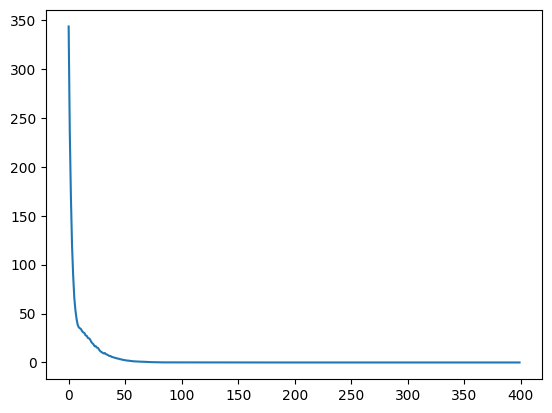

In [7]:
# Define the size of our "measurement" vector as encoding_dim. This needs to be larger than the sparsity of our matrix

# encoding_dim = max_sparsity
# encoding_dim = 100
# vector_size = 100
encoding_dim = vector_size
# Initialize model
feedthrough_model = FeedthroughEncoder(vector_size, encoding_dim)
optimizer = torch.optim.Adam(feedthrough_model.parameters(), lr=1E-2, weight_decay=1E-6)
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(20):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = feedthrough_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

#### Train the AutoEncoder Model

100
Epoch 1, Loss: 64.599457
Epoch 2, Loss: 62.241676
Epoch 3, Loss: 59.890820
Epoch 4, Loss: 52.354435
Epoch 5, Loss: 45.448074
Epoch 6, Loss: 39.794868
Epoch 7, Loss: 35.408218
Epoch 8, Loss: 33.126007
Epoch 9, Loss: 30.280630
Epoch 10, Loss: 28.642515
Epoch 11, Loss: 25.450476
Epoch 12, Loss: 24.061272
Epoch 13, Loss: 24.001869
Epoch 14, Loss: 21.932312
Epoch 15, Loss: 21.134212
Epoch 16, Loss: 21.320185
Epoch 17, Loss: 19.402077
Epoch 18, Loss: 19.053741
Epoch 19, Loss: 17.357809
Epoch 20, Loss: 18.220091
Epoch 21, Loss: 17.224504
Epoch 22, Loss: 16.722794
Epoch 23, Loss: 15.731210
Epoch 24, Loss: 16.442186
Epoch 25, Loss: 15.601315
Epoch 26, Loss: 14.420560
Epoch 27, Loss: 14.634054
Epoch 28, Loss: 14.085540
Epoch 29, Loss: 13.956408
Epoch 30, Loss: 13.573402
Epoch 31, Loss: 12.432314
Epoch 32, Loss: 12.329725
Epoch 33, Loss: 12.328003
Epoch 34, Loss: 12.724202
Epoch 35, Loss: 12.311552
Epoch 36, Loss: 11.934821
Epoch 37, Loss: 12.013778
Epoch 38, Loss: 11.544378
Epoch 39, Loss: 1

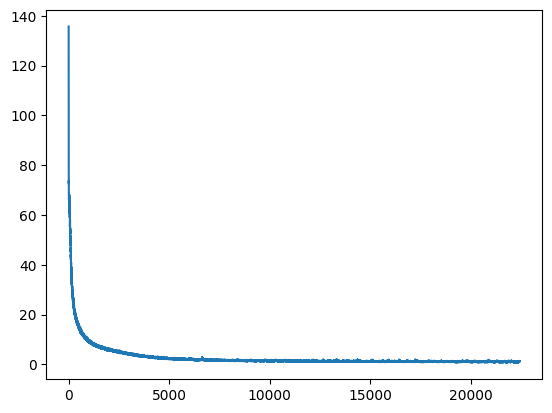

In [9]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.95
# Beta_variance: 0.99
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5

encoding_dim = 50
print(vector_size)

# Initialize model
hidden_dims = np.array([60,80])
learned_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(learned_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = learned_autoencoder_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss < lowest_loss:
        lowest_loss = loss
        early_stopping_counter = 0
        best_model = learned_autoencoder_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            learned_autoencoder_model = best_model
            print(f"stopped early after {epoch+1} epochs")
            break

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

Some conclusions that we have found so far:
- Batch size must be minimally greater than 100. 500 seems to work well.
- 2 hidden layers of size 50,70 leads to a loss of 0.3 MSE
- Decreasing variance below 0.999 does not seem to have a positive effect


## Train Noisy Models

In [127]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.9
# Beta_variance: 0.999
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5
# variance = 1
noisy_models = []
noisy_losses = []

# We define our signal to noise ratio as ranging from 0 to 20 dB

db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

for db,abs in SNR.items():
    encoding_dim = 50
    variance = signal_variance/abs
    # Initialize model
    hidden_dims = np.array([60,80])
    noisy_autoencoder_model = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
    optimizer = torch.optim.Adam(noisy_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()
# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)
    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = noisy_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = noisy_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                noisy_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss {lowest_loss:.6f}")
                break

        print(f"SNR Ratio: {db}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    noisy_models.append(best_model)
    noisy_losses.append(lowest_loss)
# plt.plot(losses)
# plt.show()

{2: 1.5848931924611136, 5: 3.1622776601683795, 8: 6.309573444801933, 11: 12.589254117941675, 14: 25.118864315095795, 17: 50.11872336272722, 20: 100.0}
83.91732681586569
Epoch 1, Loss: 75.421791
Epoch 2, Loss: 70.374718
Epoch 3, Loss: 69.811256
Epoch 4, Loss: 67.061363
Epoch 5, Loss: 65.928482
Epoch 6, Loss: 67.930763
Epoch 7, Loss: 65.763634
Epoch 8, Loss: 67.007835
Epoch 9, Loss: 65.584091
Epoch 10, Loss: 65.559502
Epoch 11, Loss: 69.017326
Epoch 12, Loss: 65.962486
Epoch 13, Loss: 64.827019
Epoch 14, Loss: 62.861195
Epoch 15, Loss: 65.970222
Epoch 16, Loss: 64.453072
Epoch 17, Loss: 65.970955
Epoch 18, Loss: 65.276688
Epoch 19, Loss: 66.390717
Epoch 20, Loss: 66.399406
Epoch 21, Loss: 68.228241
Epoch 22, Loss: 65.458008
Epoch 23, Loss: 65.989311
Epoch 24, Loss: 66.803703
Epoch 25, Loss: 64.359833
Epoch 26, Loss: 62.359230
Epoch 27, Loss: 62.604698
Epoch 28, Loss: 65.042259
Epoch 29, Loss: 63.976227
Epoch 30, Loss: 64.221558
Epoch 31, Loss: 61.808384
Epoch 32, Loss: 64.063171
Epoch 33

# Save the Noisy Models

In [133]:
for indx, (db, value) in enumerate(SNR.items()):
    torch.save(noisy_models[indx].state_dict(), f"noisy_model_{db}.pt")

## Initialize pre-trained noiseless model

In [11]:
# Instantiate your model architecture first
encoding_dim = 50
vector_size = 100
hidden_dims = np.array([50,70])
pretrained_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
pretrained_model.load_state_dict(torch.load("model_state_hidden_layers_50_70.pt"))

pretrained_model.eval()  # Set the model to evaluation mode if needed

LearnedAutoencoder(
  (encoder): ComplexLinearUnitary()
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=140, bias=True)
    (3): ReLU()
    (4): Linear(in_features=140, out_features=200, bias=True)
  )
)

## Show the output for a given sparse input vector



In [ ]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output
h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

H_hat = pretrained_model(H_tensor)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))



{2: 1.5848931924611136, 5: 3.1622776601683795, 8: 6.309573444801933, 11: 12.589254117941675, 14: 25.118864315095795, 17: 50.11872336272722, 20: 100.0}


NameError: name 'pretrained_model' is not defined

/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


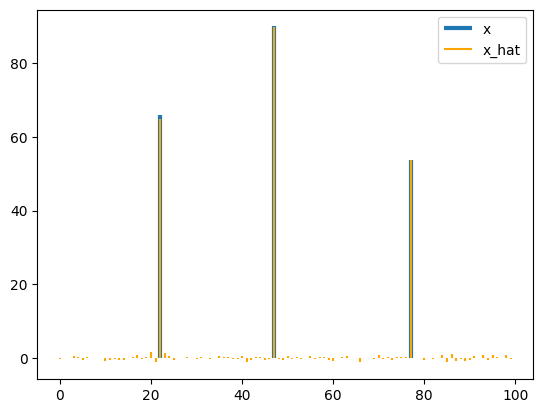

In [13]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))

## Extract the encoding matrix, generate a (noisy) y and use the decoder to find $\hat{h}$, then plot $\hat{x}$

In [ ]:
# Load the autoencoder

encoding_dim = 50
vector_size = 100
hidden_dims = np.array([60,80])
variance = 10
noisy_autoencoder = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
noisy_autoencoder.load_state_dict(torch.load("noisy_autoencoder_10var_60_80.pt",))
noisy_autoencoder.eval()

# Build the W matrix
q_values = noisy_autoencoder_model.encoder.q_values

W_real = torch.cos(q_values)
W_imag = torch.sin(q_values)
W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 

# Build the input vector

h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

y = torch.matmul(H_tensor,W_total.T)

# Make the noise

variance = 10

noise_np = np.random.normal(0,variance,size=100)
noise = torch.tensor(noise_np,dtype=torch.float)
noisy_y = y + noise

# Rebuild h, and x from the noisy y using the decoder

H_hat = noisy_autoencoder_model.decoder(noisy_y)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

x_hat = iDFT@h_hat
indices = range(len(x_hat))

/tmp/ipykernel_3959/3878500147.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())


## Plotting

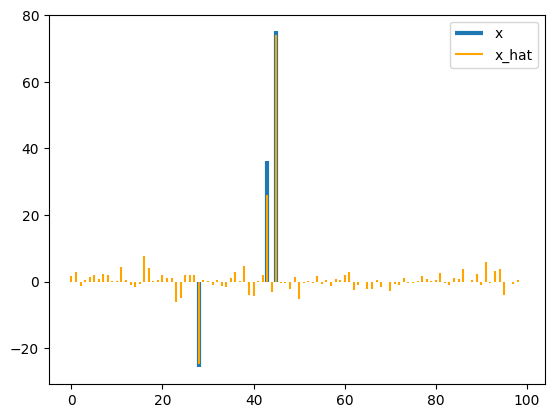

In [15]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))

## Show the weights

In [16]:
# THIS DOESN'T WORK. TO BE FIXED

for idx, layer in enumerate(pretrained_model.decoder):
    # Check if the layer is an instance of ComplexLinear
    if isinstance(layer, nn.Linear):
        print(f"Decoder layer {idx} (ComplexLinear) W_real:")
        print(layer.weight)
        print(f"Decoder layer {idx} (ComplexLinear) W_imag:")
        print(layer.weight)

Decoder layer 0 (ComplexLinear) W_real:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  0.0210,  0.0204]],
       requires_grad=True)
Decoder layer 0 (ComplexLinear) W_imag:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  

In [48]:
imbalance_levels = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = []
db_IRR_ratios = []

for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios.append(IRR_ratio)
    print(10*np.log10(IRR_ratio))
    db_IRR_ratios.append(10*np.log10(IRR_ratio))

inf
41.08929220065852
33.118820471594574
23.531709031336195
17.42758855859956
12.849459258668094


C:\Users\tomli\AppData\Local\Temp\ipykernel_31352\3469600235.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


# Train the IQ Imbalance model

In [128]:
imbalanced_models = []
imbalanced_losses = []
imbalance_levels = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}

# Calculate the dB imbalance levels, we store them in the dictionary IRR_ratios such that we can extract it with the corresponding level imbalance
for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)


C:\Users\tomli\AppData\Local\Temp\ipykernel_31352\3191029110.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


In [ ]:
# Looping over 
for level, db_ratio in IRR_ratios.items():
    encoding_dim = 50
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    variance = 0
    # Initialize model
    hidden_dims = np.array([60,80])
    imbalanced_autoencoder_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    optimizer = torch.optim.Adam(imbalanced_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()

    # def complex_mse_loss(input, target):
    #     return F.mse_loss(input, target)

    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = imbalanced_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = imbalanced_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                imbalanced_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                break
        print(f"IRR Ratio:{db_ratio}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    imbalanced_models.append(best_model)
    imbalanced_losses.append(lowest_loss)
# plt.plot(losses)
# plt.show()

# Save the IQ-Imbalance Models


In [ ]:
for indx, level, db in enumerate(IRR_ratios):
    torch.save(imbalanced_models[indx].state_dict(), f"imbalanced_model_{db:.3f}.pt")

# Train various measurement matrix size

In [192]:
measurement_sizes = [5, 10, 20, 30, 40, 50]
measurement_models = []
measurement_losses = []

for encoding_dim in measurement_sizes:
    level = 0.6 # Set the IQ imbalance level to around 33 dB IRR
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    variance = signal_variance/SNR[17] # Set the SNR to 17 dB
    # Initialize model
    hidden_dims = np.array([60,80])
    measurement_autoencoder_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    optimizer = torch.optim.Adam(measurement_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()

    # def complex_mse_loss(input, target):
    #     return F.mse_loss(input, target)

    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = measurement_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = measurement_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                measurement_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                break
        print(f"Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    measurement_models.append(best_model)
    measurement_losses.append(lowest_loss)

Encoding dimension:5, Epoch 1, Loss: 66.566055
Encoding dimension:5, Epoch 2, Loss: 66.081848
Encoding dimension:5, Epoch 3, Loss: 63.082802
Encoding dimension:5, Epoch 4, Loss: 59.852680
Encoding dimension:5, Epoch 5, Loss: 61.347771
Encoding dimension:5, Epoch 6, Loss: 60.525425
Encoding dimension:5, Epoch 7, Loss: 61.157440
Encoding dimension:5, Epoch 8, Loss: 60.828049
Encoding dimension:5, Epoch 9, Loss: 58.143780
Encoding dimension:5, Epoch 10, Loss: 55.766365
Encoding dimension:5, Epoch 11, Loss: 59.043621
Encoding dimension:5, Epoch 12, Loss: 56.845131
Encoding dimension:5, Epoch 13, Loss: 54.612583
Encoding dimension:5, Epoch 14, Loss: 55.447338
Encoding dimension:5, Epoch 15, Loss: 57.066898
Encoding dimension:5, Epoch 16, Loss: 55.444687
Encoding dimension:5, Epoch 17, Loss: 55.720390
Encoding dimension:5, Epoch 18, Loss: 56.454601
Encoding dimension:5, Epoch 19, Loss: 55.530151
Encoding dimension:5, Epoch 20, Loss: 55.524158
Encoding dimension:5, Epoch 21, Loss: 54.048061
E

# Save the measurement models

In [193]:
for indx, encoding_dim in enumerate(measurement_sizes):
    torch.save(measurement_models[indx].state_dict(), f"measurement_model_{encoding_dim}.pt")

# Plotting

In [ ]:
plt.rcParams['text.usetex'] = False

plt.plot(SNR, noisy_losses)
plt.title("Noisy Autoencoder Loss vs SNR")
plt.xlabel("SNR")
plt.ylabel("RMSE")
plt.show()


NameError: name 'SNR' is not defined

[np.float64(inf), np.float64(41.08929220065852), np.float64(33.118820471594574), np.float64(23.531709031336195), np.float64(17.42758855859956), np.float64(12.849459258668094)]
[tensor(0.9400), tensor(0.7769), tensor(1.0189), tensor(0.8167), tensor(1.1408), tensor(0.8311)]
6


C:\Users\tomli\AppData\Local\Temp\ipykernel_31352\2231548230.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


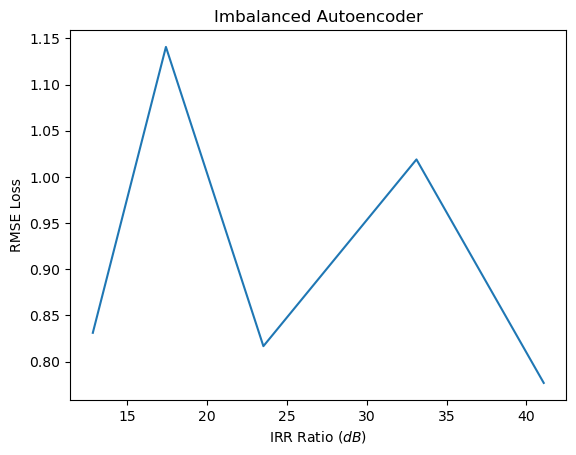

In [109]:
imbalanced_losses_np = []
for loss in imbalanced_losses:
    imbalanced_losses_np.append(torch.Tensor.detach(loss))

db_IRR_ratios = []

for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios.append(IRR_ratio)
    db_IRR_ratios.append(10*np.log10(IRR_ratio))

print(db_IRR_ratios)
print(imbalanced_losses_np)
print(len(db_IRR_ratios))
plt.figure()
plt.plot(db_IRR_ratios, imbalanced_losses_np)
plt.title("Imbalanced Autoencoder")
plt.xlabel("IRR Ratio ($dB$)")
plt.ylabel("RMSE Loss")
plt.show()

In [ ]:
# Test IQ Imbalance model

# Generate a vector
h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T


H_tensor = torch.tensor(H,dtype=torch.float)

imbalanced_autoencoder_model(H_tensor)

tensor([[  2.1940-14.0662j,  -7.8499-40.2114j, -60.2275-11.2994j,
          34.8205+17.1311j,  99.7745+3.2663j,  -7.2955+18.3390j,
           8.7409-8.3160j,  20.2890+29.3057j,  15.0064-53.3459j,
         -60.1008-2.7597j,  65.8258+17.2587j,  65.7143-45.1921j,
         -66.9343+61.2918j, 103.0347+76.0776j,  -4.2843+22.2463j,
          20.1571-34.0736j,  53.7551-111.9571j,  28.5237+122.2957j,
          29.7872-25.0511j,   9.6201+32.1166j, -64.7243+43.4759j,
          79.5069-50.4971j,  78.2422+50.0662j, -62.2079-36.2242j,
         -19.7025+48.3701j,   4.6693-62.0947j,  -5.8847-62.7116j,
          21.8569+77.5562j,  -4.8506+70.5830j, -14.7504+28.6478j,
         -24.7145+77.5106j,  35.6606+30.2751j,  60.6414-13.4909j,
          72.2780-3.7791j, -47.5546-15.8082j, -44.4641-29.0872j,
         -40.6268+40.6967j, -69.5539-56.7148j, -15.8849+47.8623j,
         -86.2923-41.9738j,  26.8706-48.0476j, -27.1463-15.7633j,
           1.1734-7.1655j,  41.7626-19.0980j, -36.8443+2.3341j,
          27.2

# Generate new dataset, initialize pretrained models, evaluate the loss and plot

In [ ]:
noisy_pretrained_models = {}
imbalanced_pretrained_models = {}
measurement_pretrained_models = {}

# Define the SNR dictionary for use
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

#Initialize pretrained noisy models
for db,abs in SNR.items():
    encoding_dim = 50
    variance = signal_variance/abs
    # Initialize model
    hidden_dims = np.array([60,80])
    noisy_pretrained_models[db] = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
    noisy_pretrained_models[db].load_state_dict(torch.load(f"noisy_model_{db}.pt", weights_only=True))

# Initialize pretrained imbalanced models
for level, db  in IRR_ratios.items():
    encoding_dim = 50
    variance = 0
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    # Initialize model
    hidden_dims = np.array([60,80])
    imbalanced_pretrained_models[level] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    imbalanced_pretrained_models[level].load_state_dict(torch.load(f"imbalanced_model_{db:.3f}.pt", weights_only=True))

# Initialize pretrained imbalanced models
for encoding_dim  in measurement_sizes:
    variance = signal_variance/SNR[17]
    level = 0.6
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    # Initialize model
    hidden_dims = np.array([60,80])
    measurement_pretrained_models[encoding_dim] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    measurement_pretrained_models[encoding_dim].load_state_dict(torch.load(f"measurement_model_{encoding_dim}.pt", weights_only=True))

5
10
20
30
40
50


In [ ]:
# Generate dataset
max_amplitude = 100
min_sparsity = 3
max_sparsity = 5
vector_size = 100
data_set_size = 10000
val_dense_data, val_sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

print(val_sparse_data[0,:])

X_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T
Y_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T

X_val_tensor = torch.tensor(X_val,dtype=torch.float)
Y_val_tensor = torch.tensor(Y_val,dtype=torch.float)
val_dataset = TensorDataset(X_val_tensor,Y_val_tensor)

dataloader_val = DataLoader(val_dataset,batch_size = 500,shuffle = True, )

loss_fn = nn.MSELoss()

[0. 0. 0. ... 0. 0. 0.]
[38.2201252  18.97622709  9.33666549  5.84045994  4.15966655  3.66885085
  3.5729544 ]


In [ ]:

# Validating the noisy models
noisy_val_losses = []
noisy_model_losses = []

with torch.no_grad():
    for db, noisy_model in noisy_pretrained_models.items():
        noisy_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = noisy_model(inputs)
            loss = loss_fn(output, targets)
            noisy_model_losses.append(loss.item())
        noisy_val_losses.append(np.average(noisy_model_losses))
        noisy_model_losses = []

noisy_val_losses = np.array(noisy_val_losses)
normalized_noisy_val_losses = noisy_val_losses/signal_variance
print(noisy_val_losses)

In [168]:
# Validating the IQ imbalance models
imbalance_model_losses = []
imbalance_val_losses = []

with torch.no_grad():
    for level, imbalance_model in imbalanced_pretrained_models.items():
        imbalance_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = noisy_model(inputs)
            loss = loss_fn(output, targets)
            imbalance_model_losses.append(loss.item())
        imbalance_val_losses.append(np.average(imbalance_model_losses))
        imbalance_model_losses = []

imbalance_val_losses = np.array(imbalance_val_losses)
normalized_imbalance_val_losses = imbalance_val_losses/signal_variance
print(imbalance_val_losses)

[3.56558046 3.5617631  3.56672719 3.56821227 3.5680975  3.57855914]


In [ ]:
# Validating the varying measurement dimensions models
measurement_model_losses = []
measurement_val_losses = []

with torch.no_grad():
    for encoding_dim, measurement_model in measurement_pretrained_models.items():
        measurement_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = measurement_model(inputs)
            loss = loss_fn(output, targets)
            measurement_model_losses.append(loss.item())
        measurement_val_losses.append(np.average(measurement_model_losses))
        print(f"Encoding dimenson:{encoding_dim} Losses:{measurement_model_losses}")
        measurement_model_losses = []

measurement_val_losses = np.array(measurement_val_losses)
normalized_measurement_val_losses = measurement_val_losses/signal_variance

Encoding dimenson:5 Losses:[55.38413619995117, 49.81441879272461, 52.200706481933594, 53.87385940551758, 53.9869499206543, 51.2041015625, 53.13970947265625, 52.45096969604492, 51.7727165222168, 51.001190185546875, 51.51372146606445, 47.967018127441406, 52.526729583740234, 52.67061996459961, 51.90864944458008, 53.721981048583984, 51.803009033203125, 53.87192153930664, 55.392730712890625, 49.66065979003906]
Encoding dimenson:10 Losses:[37.98468017578125, 38.62479019165039, 34.6104736328125, 35.81454849243164, 35.69164276123047, 38.843238830566406, 37.82549285888672, 34.469207763671875, 36.85490036010742, 36.372257232666016, 36.139286041259766, 36.42307662963867, 35.425838470458984, 37.715911865234375, 38.15034866333008, 37.091426849365234, 36.12796401977539, 34.92387390136719, 35.395660400390625, 36.71246337890625]
Encoding dimenson:20 Losses:[19.04438591003418, 19.00229263305664, 16.888687133789062, 18.0958251953125, 18.082151412963867, 18.615463256835938, 19.05517578125, 19.62303543090

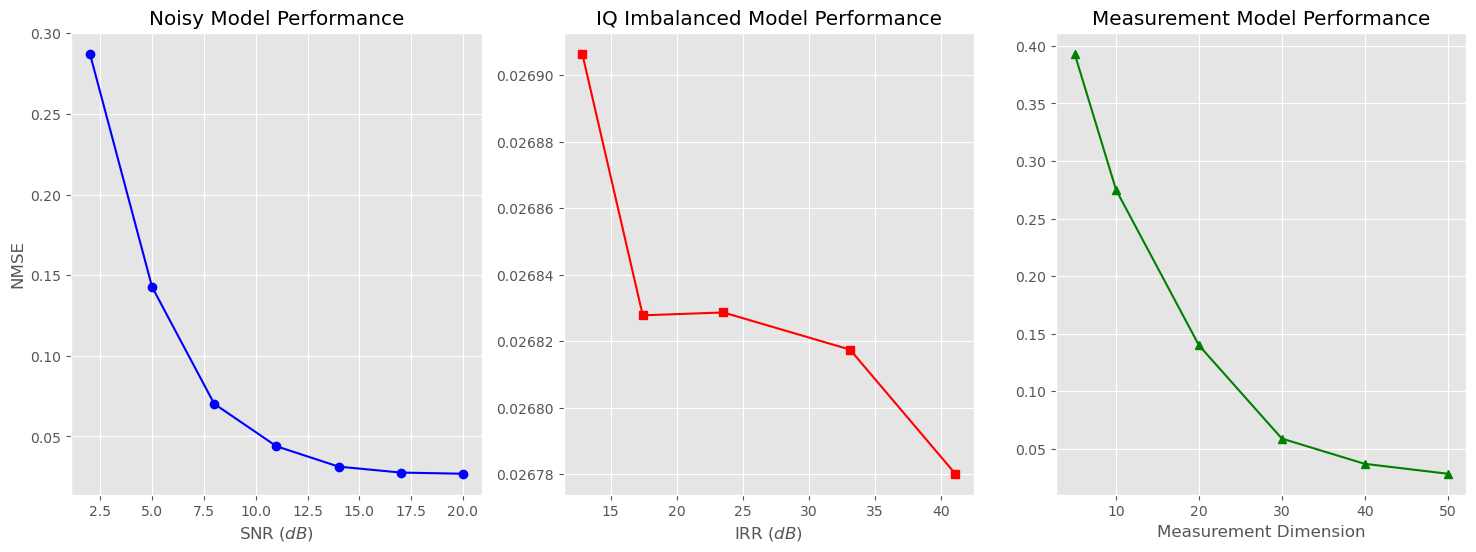

In [203]:
plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))
ax1.plot(SNR.keys(),normalized_noisy_val_losses,color= "blue", marker="o")
ax1.set_xlabel("SNR $(dB)$")
ax1.set_ylabel("NMSE")
ax1.set_title("Noisy Model Performance")
ax1.grid(True)

ax2.plot(IRR_ratios.values(),normalized_imbalance_val_losses,color= 'red',marker='s')
ax2.set_xlabel("IRR $(dB)$")
ax2.set_title("IQ Imbalanced Model Performance")
ax2.grid(True)

ax3.plot(measurement_sizes,normalized_measurement_val_losses,color= 'green',marker='^')
ax3.set_xlabel("Measurement Dimension")
ax3.set_title("Measurement Model Performance")
ax3.grid(True)